## Convert .wav files to Mel Frequency Cepstral Coefficients (MFCCs)

Previously, we have fed spectrograms to our CNN, with limited success. We'll now try to extract MFCC features, so that we can train on those instead.  
  
**Overview** <sup>1</sup>:  
  
An audio signal is constantly changing, so to simplify things we frame the signal into 20-40ms frames. If the frame is much shorter we don't have enough samples to get a reliable spectral estimate, if it is longer the signal changes too much throughout the frame.

The next step is to calculate the power spectrum of each frame. This is motivated by the human cochlea, which vibrates at different spots depending on the frequency of the incoming sounds. The periodogram estimate performs a similar job for us, identifying which frequencies are present in the frame.

The periodogram spectral estimate still contains a lot of information not required for Automatic Speech Recognition (ASR). In particular the cochlea can not discern the difference between two closely spaced frequencies. This effect becomes more pronounced as the frequencies increase. For this reason we take clumps of periodogram bins and sum them up to get an idea of how much energy exists in various frequency regions. This is performed by our Mel filterbank: the first filter is very narrow and gives an indication of how much energy exists near 0 Hertz. As the frequencies get higher our filters get wider as we become less concerned about variations. We are only interested in roughly how much energy occurs at each spot. The Mel scale tells us exactly how to space our filterbanks and how wide to make them.

Once we have the filterbank energies, we take the logarithm of them. This is also motivated by human hearing: we don't hear loudness on a linear scale. Generally to double the percieved volume of a sound we need to put 8 times as much energy into it. This means that large variations in energy may not sound all that different if the sound is loud to begin with. This compression operation makes our features match more closely what humans actually hear.

The final step is to compute the DCT (Discrete Cosine Transform) of the log filterbank energies. Because our filterbanks are all overlapping, the filterbank energies are quite correlated with each other. The DCT decorrelates the energies so that diagonal covariance matrices can be used to model the features in e.g. a HMM classifier. Only 12 of the 26 DCT coefficients are kept. This is because the higher DCT coefficients represent fast changes in the filterbank energies and it turns out that these fast changes actually degrade ASR performance, so we get a small improvement by dropping them.  
  
<sup>1</sup>_from http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/_  

Further information: http://www.speech.cs.cmu.edu/15-492/slides/03_mfcc.pdf

### 1) Load packages and define filepaths

In [1]:
# import packages
import numpy as np
import scipy.io.wavfile
import os
from scipy.fftpack import dct
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
# Location of source .wav files to convert. Each session has two recordings from two different microphones.

dir_names = ['data/TORGO/F01/Session1',
            'data/TORGO/F03/Session1','data/TORGO/F03/Session2','data/TORGO/F03/Session3',
            'data/TORGO/F04/Session1','data/TORGO/F04/Session2',
            'data/TORGO/M01/Session1','data/TORGO/M01/Session2_3',
            'data/TORGO/M02/Session1','data/TORGO/M02/Session2',
            'data/TORGO/M03/Session2',
            'data/TORGO/M04/Session1','data/TORGO/M04/Session2',
            'data/TORGO/M05/Session1','data/TORGO/M05/Session2']
mics = ['wav_headMic','wav_arrayMic']

### 2) Define Parameters

In [3]:
# Set pre-emphasis, which is used to amplify high frequencies
# Typically set to 0.95 or 0.97
pre_emphasis = 0.97

# Set frame size and stride in ms. Frame size is usually 20 - 40ms, with a 50% overlap
frame_size = 0.025
frame_stride = 0.01

# Need value for N-point Fast Fourier Transform (also called Short Time Fourier Transform)
# N is typically 256 or 512
NFFT = 512

# Select the number of filters to apply to the power spectrum (normally 40)
nfilt = 40

# Select the number of cepstral coefficients to keep (normally 12)
num_ceps = 12

# Set a factor to shift the MFCC's by (normally 22)
cep_lifter = 22

### 3) Define function to convert .wav file to an array of MFCC's

In [4]:
### Based heavily on Hatham Fayek's explanation of MFCC's 
### https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html#fn:1

def create_mfcc(path, **kwargs):
    """
    A function that creates an array of MFCCs from an audio file
    Each column represents one of 12 cepstral coefficents
    Each row is a small window of time (defined by frame_size), so the
    number of rows will vary depending upon the length of the clip
    For visualization purposes, it may therefore be easier to look at 
    the transpose so that the x-axis represents time
    """
    # 1) Read in data
    sample_rate, signal = scipy.io.wavfile.read(path)
    
    # 2) Amplify high frequencies using pre-emphasis factor
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # 3) Break signal into multiple overlapping frames
    frame_length = frame_size * sample_rate
    frame_step = frame_stride * sample_rate
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # 4) Apply Hamming window to smooth any discontinuities at beginning or
    #    end of the sampled frame
    frames *= np.hamming(frame_length)

    # 5) Apply Short Time Fourier Transform
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    
    # 6) Compute the power spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # 7) Apply filter banks to the power spectrum (on mel scale) to extract frequency bands
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # 8) Mean normalize the filter banks to balance the spectrum and improve signal to noise ratio
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

    # 9) Apply Discrete Cosine Transform to decorrelate filter banks and yield a compressed representation
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    return mfcc

### 4) Test the function on a sample file

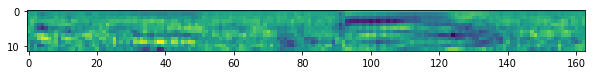

In [5]:
test_path = 'data/TORGO/F01/Session1/wav_arrayMic/0060.wav'
test_mfcc = create_mfcc(test_path)

plt.figure(figsize=(10,10))
plt.imshow(test_mfcc.T, aspect = 1)

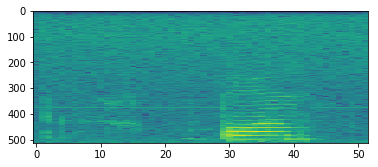

In [7]:
# compare to spectrogram (stretched along x-axis for easier comparison)
test_spect = 'data/TORGO/F01/Session1/wav_arrayMic_spect/0060.png'
img = plt.imread(test_spect)
plt.imshow(img, aspect = 0.04)

### 5) Run loop to create MFCC image files

In [8]:
def create_png(mfcc, png_name):
    """
    Save grayscale png of spectrogram.
    """
    image = Image.fromarray(mfcc)
    image = image.convert('L')  # convert to grayscale
    image.save(png_name)

In [9]:
for d in dir_names:
    for m in mics:
        dir_name = d + '/' + m
        print('Processing directory' + dir_name + '...')
        if not os.path.exists(dir_name + '_mfcc/'):
            os.makedirs(dir_name + '_mfcc/')
        for subdir, dirs, files in os.walk(dir_name):
            for file in files:
                if file.endswith('.wav'):
                    wav_file = os.path.join(subdir, file)
                    png_name = subdir + '_mfcc/' + file[:-4] + '.png'
                    try:
                        create_png(create_mfcc(wav_file), png_name=png_name) 
                        #stft_matrix(wav_file, png_name=png_name, save_png=True)
                    except:
                        print('WARNING: Unable to convert ' + file)
                        pass

print("MFCC Conversion Complete!")

Processing directorydata/TORGO/F01/Session1/wav_headMic...
Processing directorydata/TORGO/F01/Session1/wav_arrayMic...
Processing directorydata/TORGO/F03/Session1/wav_headMic...
Processing directorydata/TORGO/F03/Session1/wav_arrayMic...
Processing directorydata/TORGO/F03/Session2/wav_headMic...
Processing directorydata/TORGO/F03/Session2/wav_arrayMic...
Processing directorydata/TORGO/F03/Session3/wav_headMic...
Processing directorydata/TORGO/F03/Session3/wav_arrayMic...
Processing directorydata/TORGO/F04/Session1/wav_headMic...
Processing directorydata/TORGO/F04/Session1/wav_arrayMic...
Processing directorydata/TORGO/F04/Session2/wav_headMic...
Processing directorydata/TORGO/F04/Session2/wav_arrayMic...
Processing directorydata/TORGO/M01/Session1/wav_headMic...
Processing directorydata/TORGO/M01/Session1/wav_arrayMic...
Processing directorydata/TORGO/M01/Session2_3/wav_headMic...
Processing directorydata/TORGO/M01/Session2_3/wav_arrayMic...
Processing directorydata/TORGO/M02/Session1/